In [1]:
import os
import numpy as np
import cv2
from numpy.linalg import norm
import heapq
import multiprocessing
import time

x_slice = 5
y_slice = 5


class FeatureExtractor:
    def __init__(self, dataset_folder):
        self.dataset_folder = dataset_folder

    def prepare_reference(self, dataset, folder='Reference'):
        raise NotImplementedError()

    def extract_from_dataset(self):
        raise NotImplementedError()


# * [Grid Color Moments](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/KEEN/av_as2_nkeen.pdf)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
class GridColorMomentsExtractor(FeatureExtractor):
    def __init__(self, dataset_folder):
        super().__init__(dataset_folder)
        if not os.path.isfile(f'{dataset_folder}-Reference.npy'):
            self.prepare_reference(dataset_folder)
        self.reference = np.load(f'{dataset_folder}-Reference.npy')

    def prepare_reference(self, dataset, folder='Reference'):
        train_data_path = os.path.join(dataset, folder)
        images = sorted([item for item in os.listdir(
            train_data_path) if item.endswith('.jpg')])
        total = len(images)

        print('-'*30)
        print('Preparing reference...')
        print('-'*30)

        image_moments = np.ndarray((total, x_slice, y_slice, 3, 3), np.float32)

        for idx, image_name in enumerate(images):
            img = cv2.imread(os.path.join(train_data_path, image_name))
            dx = img.shape[0] // x_slice
            dy = img.shape[1] // y_slice

            for i in range(x_slice):
                for j in range(y_slice):
                    img_slice = img[i*dx:(i+1)*dx, j*dy:(j+1)*dy]
                    slice_moment = GridColorMomentsExtractor.color_moments(
                        img_slice)
                    image_moments[idx][i][j] = slice_moment

            if idx % 10 == 0:
                print(f'Done: {idx}/{total} images')

        print('Loading done.')

        np.save(f'{dataset}-{folder}.npy', image_moments)
        print(f'Saving to {dataset}-{folder}.npy files done.')

    def extract_from_dataset(self):
        subfolders = [item for item in os.listdir(self.dataset_folder) if item not in [
            ".DS_Store", "Reference"]]
        top1_sum = 0
        top5_sum = 0
        total_count = 0
        for subfolder in subfolders:
            top1_count, top5_count = self._extract_from_subfolder(subfolder)
            top1_sum += top1_count
            top5_sum += top5_count
            total_count += len(self.reference)

        return top1_sum, top5_sum, total_count

    def _extract_from_subfolder(self, subfolder):
        train_data_path = os.path.join(self.dataset_folder, subfolder)
        images = sorted([item for item in os.listdir(
            train_data_path) if item.endswith('.jpg')])

        total = len(images)

        print('-'*30)
        print(f'Classifying {subfolder}...')
        print('-'*30)

        top1_count = 0
        top5_count = 0

        weight = np.reshape(np.array(x_slice * y_slice * [
            [1, 0, 0],
            [0, 2, 0],
            [0, 0, 1]
        ]), (x_slice, y_slice, 3, 3))

        for idx, image_name in enumerate(images):
            img = cv2.imread(os.path.join(train_data_path, image_name))
            dx = img.shape[0] // x_slice
            dy = img.shape[1] // y_slice

            image_moment = np.ndarray((x_slice, y_slice, 3, 3), np.float32)

            for i in range(x_slice):
                for j in range(y_slice):
                    img_slice = img[i*dx:(i+1)*dx, j*dy:(j+1)*dy]
                    slice_moment = GridColorMomentsExtractor.color_moments(
                        img_slice)
                    image_moment[i][j] = slice_moment

            possible_values = []
            for reference_index in range(self.reference.shape[0]):
                substracted_mat = np.subtract(
                    self.reference[reference_index], image_moment)
                mat = np.matmul(substracted_mat, weight)
                distance = norm(mat)
                heapq.heappush(possible_values, (distance, reference_index))

            top5_values = []
            for i in range(5):
                top5_values.append(heapq.heappop(possible_values))
            top5 = [index for distance, index in top5_values]

            if idx in top5_values[0]:
                top1_count += 1
                print(f'hit: {image_name}! Distance:{top5_values[0][0]}')

            if idx in top5:
                top5_count += 1
                distance, index = [
                    entry for entry in top5_values if entry[1] == idx][0]
                print(f'hit in top 5: {image_name}! Distance:{distance}')

            if idx % 10 == 0:
                print(f'Done: {idx}/{total} images')

        print('All done.')
        return top1_count, top5_count

    @staticmethod
    def color_moments(img):
        if img is None:
            return
        # Convert BGR to HSV colorspace
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Split the channels - h,s,v
        h, s, v = cv2.split(hsv)
        # Initialize the color feature
        color_feature = []
        # N = h.shape[0] * h.shape[1]
        # The first central moment - average
        h_mean = np.mean(h)  # np.sum(h)/float(N)
        s_mean = np.mean(s)  # np.sum(s)/float(N)
        v_mean = np.mean(v)  # np.sum(v)/float(N)
        color_feature.append([h_mean, s_mean, v_mean])
        # The second central moment - standard deviation
        h_std = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
        s_std = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
        v_std = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
        color_feature.append([h_std, s_std, v_std])
        # The third central moment - the third root of the skewness
        h_skewness = np.mean(abs(h - h.mean())**3)
        s_skewness = np.mean(abs(s - s.mean())**3)
        v_skewness = np.mean(abs(v - v.mean())**3)
        h_thirdMoment = h_skewness**(1./3)
        s_thirdMoment = s_skewness**(1./3)
        v_thirdMoment = v_skewness**(1./3)
        color_feature.append([h_thirdMoment, s_thirdMoment, v_thirdMoment])

        return np.array(color_feature)

In [1]:
class GaborExtractor(FeatureExtractor):

    def __init__(self, dataset_folder):
        super().__init__(dataset_folder)
        self.kernels = GaborExtractor.gabor_kernel()
        if not os.path.isfile(f'{dataset_folder}-Reference.npy'):
            self.prepare_reference(dataset_folder)
        self.reference = np.load(f'{dataset_folder}-Reference.npy')

    @staticmethod
    def convolution(image, filters):
        result = np.zeros_like(image, dtype=float)
        # Normalize images for better comparison.
        # image = (image - image.mean()) // image.std()
        for kern in filters:
            fimg = cv2.filter2D(image, cv2.CV_64FC3, kern)
            np.maximum(result, fimg, result)
        return result

    @staticmethod
    def gabor_kernel():
        filters = []
        ksize = 32
        # define the range for theta and nu
        for theta in np.arange(0, np.pi, np.pi / 8):
            for nu in np.arange(np.pi / 4, 6*np.pi/4, np.pi / 4):
                kern = cv2.getGaborKernel(
                    (ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
                kern /= 1.5*kern.sum()
                filters.append(kern)
        return np.array(filters)

    def feature_from_image(self, image):
        # initializing the feature vector
        feat = []
        # calculating the local energy for each convolved image
        for j in range(self.kernels.shape[0]):
            res = GaborExtractor.convolution(image, self.kernels[j])
            feat.append(np.mean(res))
            feat.append(np.std(res))
        return np.array(feat)

    def prepare_reference(self, dataset, folder='Reference'):
        train_data_path = os.path.join(dataset, folder)
        image_list = sorted([item for item in os.listdir(
            train_data_path) if item.endswith('.jpg')])
        total = len(image_list)

        print('-'*30)
        print('Preparing reference...')
        print('-'*30)

        features = np.ndarray((total, 80), np.float32)

        async_results = []
        pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
        for idx, image_name in enumerate(image_list):
            img = cv2.imread(os.path.join(train_data_path, image_name))
            img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)
            async_results.append(pool.apply_async(
                self._reference_worker, (img, idx)))
        pool.close()
        pool.join()

        for async_result in async_results:
            feature, idx = async_result.get()
            features[idx] = feature
        print('Loading done.')

        np.save(f'{dataset}-{folder}.npy', features)
        print(f'Saving to {dataset}-{folder}.npy files done.')

    def extract_from_dataset(self):
        subfolders = [item for item in os.listdir(self.dataset_folder) if not item.startswith('.') and item != 'Reference']
        top1_sum = 0
        top5_sum = 0
        total_count = 0
        for subfolder in subfolders:
            top1_count, top5_count = self._extract_from_subfolder(subfolder)
            top1_sum += top1_count
            top5_sum += top5_count
            total_count += len(self.reference)

        return top1_sum, top5_sum, total_count

    def _extract_from_subfolder(self, subfolder):
        train_data_path = os.path.join(self.dataset_folder, subfolder)
        images = sorted([item for item in os.listdir(
            train_data_path) if item.endswith('.jpg')])

        total = len(images)
        top1_count = 0
        top5_count = 0

        print('-'*30)
        print(f'Classifying {subfolder}...')
        print('-'*30)
        start = time.time()
        pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
        async_results = []
        for idx, image_name in enumerate(images):
            img = cv2.imread(os.path.join(train_data_path, image_name))
            img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)
            # top1, top5 = self._worker(idx, img, image_name, total)
            # top1_count += top1
            # top5_count += top5
            async_results.append(pool.apply_async(
                self._worker, (idx, img, image_name, total)))
        pool.close()
        pool.join()

        for async_result in async_results:
            top1, top5 = async_result.get()
            top1_count += top1
            top5_count += top5

        end = time.time()
        print(f"time:{end - start}")
        print('All done.')
        return top1_count, top5_count

    def _reference_worker(self, img, idx):
        feature = self.feature_from_image(img)
        return feature, idx

    def _worker(self, idx, img, image_name, total):
        feature = self.feature_from_image(img)
        possible_values = []
        top1_count = 0
        top5_count = 0
        for reference_index in range(self.reference.shape[0]):
            substracted_mat = np.subtract(
                self.reference[reference_index], feature)
            distance = norm(substracted_mat)
            heapq.heappush(possible_values, (distance, reference_index))
        top5_values = []
        for i in range(5):
            top5_values.append(heapq.heappop(possible_values))
        top5 = [index for distance, index in top5_values]

        if idx in top5_values[0]:
            top1_count += 1
            print(f'hit: {image_name}! Distance:{top5_values[0][0]}')

        if idx in top5:
            top5_count += 1
            distance, index = [
                entry for entry in top5_values if entry[1] == idx][0]
            print(f'hit in top 5: {image_name}! Distance:{distance}')
        if idx % 10 == 0:
            print(f'Done: {idx}/{total} images')

        return top1_count, top5_count


class DogSIFTExtactor(FeatureExtractor):
    def __init__(self, dataset_folder):
        self.dataset_folder = dataset_folder
        if not os.path.isfile(f'{dataset_folder}-Reference.npy'):
            self.prepare_reference(dataset_folder)
        self.reference = np.load(f'{dataset_folder}-Reference.npy')
    
    def prepare_reference(self, dataset, folder='Reference'):
        pass
    def extract_from_dataset(self):
        train_data_path = os.path.join(self.dataset_folder, 'Reference')
        image_list = sorted([item for item in os.listdir(
            train_data_path) if item.endswith('.jpg')])
        total = len(image_list)
        
        print('-'*30)
        print(f'Classifying Reference...')
        print('-'*30)
        
        for idx, image_name in enumerate(image_list[:1]):
            img = cv2.imread(os.path.join(train_data_path, image_name))
            gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            sift = cv2.xfeatures2d.SIFT_create()
            kp = sift.detect(gray,None)
            img = cv2.drawKeypoints(gray,kp)
            plt.imshow(img, cmap='gray')
            plt.show()

NameError: name 'FeatureExtractor' is not defined

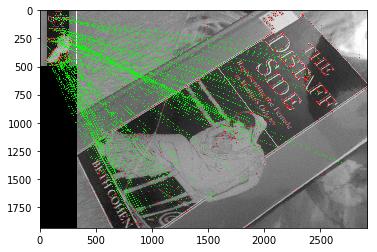

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.pyplot import figure
# import cv2
# import imutils

# sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detect(gray,None)
# img = cv2.drawKeypoints(gray,kp, np.array([]))
# plt.imshow(img, cmap='gray')
# plt.show()

# print(f"top1:{top1result/total_count}")
# print(f"top5:{top5result/total_count}")

import numpy as np
import cv2
from matplotlib import pyplot as plt
folder = '/Users/shawnhung/Documents/CognitiveHomework/hw2/dataset/book_covers'

img1 = cv2.imread(f'{folder}/Reference/001.jpg',0)          # queryImage

img2 = cv2.imread(f'{folder}/Droid/001.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3)
plt.show()